In [1]:
from google.colab import drive
drive.mount("./drive")

Mounted at ./drive


In [2]:
!pip install livelossplot

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *

from livelossplot import PlotLossesKeras

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.ensemble import *

import cv2
from PIL import Image

import numpy as np
import scipy
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm, notebook

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile
print("All modules are successfull loaded")

All modules are successfull loaded


In [4]:
with ZipFile("./drive/MyDrive/DockShip_Hiring_Challenge/attentive_ai_internship_hiring_challenge-dataset.zip") as file:
    file.extractall()
file.close()
print("Extraction Done")

Extraction Done


In [5]:
TRAIN_DATA = "./merged_data/train"
TEST_DATA = "./merged_data/test"
TRAIN_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/train_csv.csv"
TEST_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/test_csv.csv"
WORK_DIR = "./drive/MyDrive/DockShip_Hiring_Challenge/"

# Time to get our hands dirty

In [6]:
train_csv = pd.read_csv(TRAIN_CSV)
test_csv = pd.read_csv(TEST_CSV)

In [7]:
train_csv

,0,1,paths,img_shape
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)"
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)"
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)"
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)"
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)"
...,...,...,...,...
8639,8639.jpg,Adhered,./merged_data/train/8639.jpg,"(3, 1502, 1598)"
8640,8640.jpg,Adhered,./merged_data/train/8640.jpg,"(3, 1674, 358)"
8641,8641.jpg,Adhered,./merged_data/train/8641.jpg,"(3, 4070, 6005)"
8642,8642.jpg,Adhered,./merged_data/train/8642.jpg,"(3, 294, 493)"


In [8]:
test_csv

,0,1,paths,img_shape
0,0.jpg,Adhered,./merged_data/test/0.jpg,"(3, 609, 388)"
1,1.jpg,Adhered,./merged_data/test/1.jpg,"(3, 90, 43)"
2,2.jpg,Adhered,./merged_data/test/2.jpg,"(3, 211, 365)"
3,3.jpg,Adhered,./merged_data/test/3.jpg,"(3, 1818, 913)"
4,4.jpg,Adhered,./merged_data/test/4.jpg,"(3, 433, 105)"
...,...,...,...,...
591,591.jpg,Adhered,./merged_data/test/591.jpg,"(3, 4080, 3220)"
592,592.jpg,Adhered,./merged_data/test/592.jpg,"(3, 635, 682)"
593,593.jpg,Adhered,./merged_data/test/593.jpg,"(3, 117, 284)"
594,594.jpg,Adhered,./merged_data/test/594.jpg,"(3, 901, 720)"


# Augmenting data

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

for idx,(tr_,te_) in enumerate(skf.split(train_csv["paths"],y=train_csv["1"])):
    train_csv.loc[te_,'kfold']=idx

In [10]:
train_csv

,0,1,paths,img_shape,kfold
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)",3.0
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)",1.0
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)",1.0
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)",0.0
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)",1.0
...,...,...,...,...,...
8639,8639.jpg,Adhered,./merged_data/train/8639.jpg,"(3, 1502, 1598)",1.0
8640,8640.jpg,Adhered,./merged_data/train/8640.jpg,"(3, 1674, 358)",0.0
8641,8641.jpg,Adhered,./merged_data/train/8641.jpg,"(3, 4070, 6005)",0.0
8642,8642.jpg,Adhered,./merged_data/train/8642.jpg,"(3, 294, 493)",1.0


In [11]:
len(os.listdir("./merged_data/train"))

8644

In [12]:
def dataAugmentWithSkf(train_data, img_shape, preprocessing_function=None, batch_size = 64, img_dir = "/content/merged_data/train", x_col = "paths", y_col = "1"):

    train_data[y_col] = train_data[y_col].astype(str) 
    train_exmpls = train_data[train_data.kfold!=0]
    val_exmpls = train_data[train_data.kfold==0]
    # train_data[y_col] = train_data[y_col].astype('float32')

    trainGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                  rotation_range = 270,
                                  zoom_range = 0.2,
                                #   cval = 0.,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                #   shear_range = 0.15,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  brightness_range = [0.2, 0.5],
                                  rescale = 1/255.,                       
                                )

    train_set = trainGen.flow_from_dataframe(train_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )

    valGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                rescale = 1/255.                                
                                )

    val_set = valGen.flow_from_dataframe(val_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )
       
    return train_set, val_set

In [13]:
img_shape = [224, 224]
train_set, val_set = dataAugmentWithSkf(train_csv,
                                        img_shape,
                                        x_col = "0",
                                        y_col = '1',
                                        )

Found 6915 validated image filenames belonging to 6 classes.
Found 1729 validated image filenames belonging to 6 classes.


In [14]:
classes = train_set.class_indices
classes

{'Adhered': 0,
 'Ballasted': 1,
 'Concrete': 2,
 'Plastic & fabric': 3,
 'Shingle': 4,
 'Steel': 5}

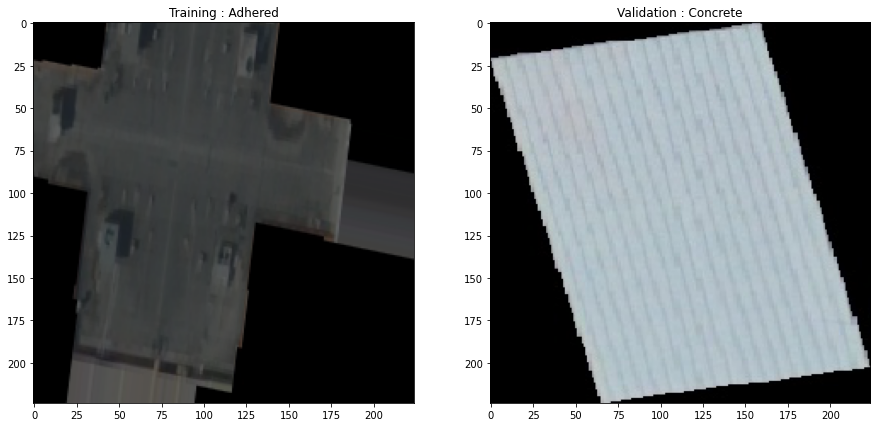

In [15]:
idx = np.random.randint(len(next(train_set)[0]))
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.imshow((next(train_set)[0][idx]));
plt.title(f"Training : {list(classes.keys())[list(next(train_set)[1][idx]).index(1)]}")

plt.subplot(1, 2, 2)
plt.imshow((next(val_set)[0][idx]));
plt.title(f"Validation : {list(classes.keys())[list(next(val_set)[1][idx]).index(1)]}")
plt.show();

# Building a model

In [60]:
def create_model(img_shape = 224, n_classes = 6):

    pmodel = Xception(input_shape = (img_shape, img_shape, 3), include_top = False,
                             weights = 'imagenet')
    layer_count = 0
    untrained_layers = 0
    tlayers = len(list(pmodel.layers))
    print(f"Total layers : {tlayers}")
    # print(f"last layer_name : {list(pmodel.layers)[len(pmodel.layers)-1].name}")
    for layer in pmodel.layers:
        layer_count += 1
        if layer_count > tlayers//2:
            layer.trainable = True
            print(layer.name)
            untrained_layers += 1
        else:
            layer.trainable = False
    print(f"Total Trainable Layers : {untrained_layers}")
    # print(pmodel.name)
    x = GlobalAveragePooling2D()(pmodel.output)
    # x = Dense(256, activation = 'relu', )(x)
    # x = Dropout(0.5)(x)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(inputs = pmodel.input, outputs = output, name = pmodel.name)
    return model

model = create_model()

83689472/83683744 [==============================] - 1s 0us/step
Total layers : 132
block8_sepconv1_act
block8_sepconv1
block8_sepconv1_bn
block8_sepconv2_act
block8_sepconv2
block8_sepconv2_bn
block8_sepconv3_act
block8_sepconv3
block8_sepconv3_bn
add_6
block9_sepconv1_act
block9_sepconv1
block9_sepconv1_bn
block9_sepconv2_act
block9_sepconv2
block9_sepconv2_bn
block9_sepconv3_act
block9_sepconv3
block9_sepconv3_bn
add_7
block10_sepconv1_act
block10_sepconv1
block10_sepconv1_bn
block10_sepconv2_act
block10_sepconv2
block10_sepconv2_bn
block10_sepconv3_act
block10_sepconv3
block10_sepconv3_bn
add_8
block11_sepconv1_act
block11_sepconv1
block11_sepconv1_bn
block11_sepconv2_act
block11_sepconv2
block11_sepconv2_bn
block11_sepconv3_act
block11_sepconv3
block11_sepconv3_bn
add_9
block12_sepconv1_act
block12_sepconv1
block12_sepconv1_bn
block12_sepconv2_act
block12_sepconv2
block12_sepconv2_bn
block12_sepconv3_act
block12_sepconv3
block12_sepconv3_bn
add_10
block13_sepconv1_act
block13_sepc

In [61]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

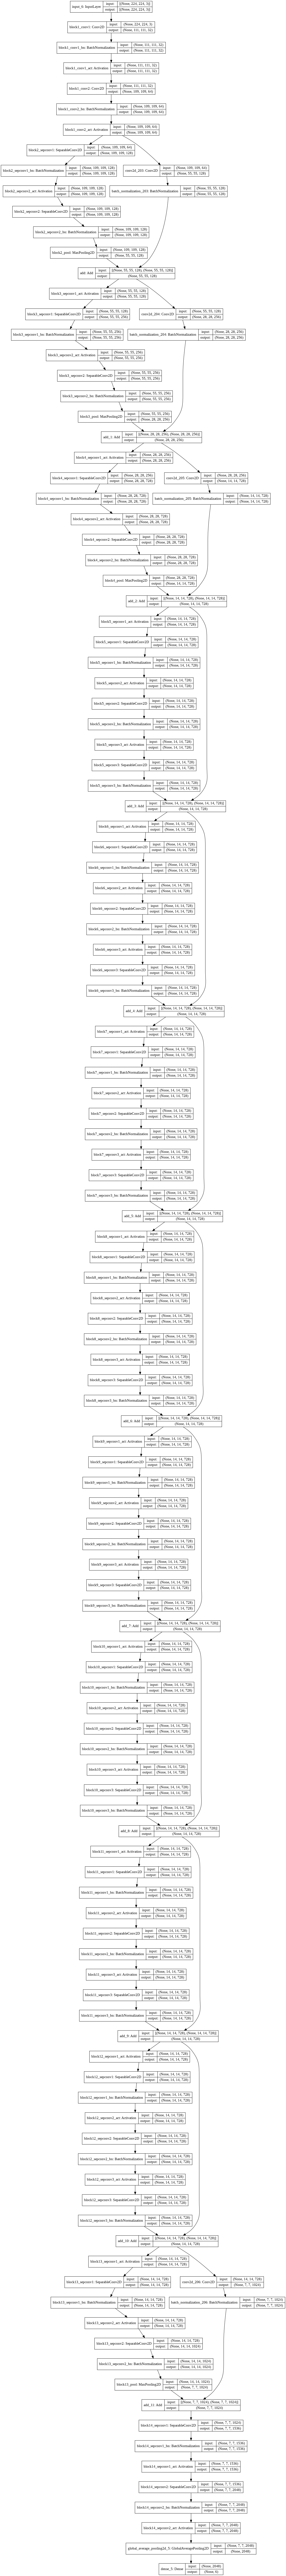

In [62]:
plot_model(model, to_file=os.path.join(WORK_DIR, f"{model.name}.png"), show_shapes=True, show_layer_names=True)

In [64]:
# class_weights = {}
# sum = 0
# for class_ in classes:
#     class_weights[classes[class_]] = 1/(len(train_csv[train_csv['1'] == class_])/len(train_csv))
#     sum += 1/(len(train_csv[train_csv['1'] == class_])/len(train_csv))
# class_weights

In [65]:
n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, 
                              verbose=1, mode='min', min_lr = 1e-7)

model_Best_save = ModelCheckpoint(f"/content/ModelCheckpoints/{model.name}.h5",
                                                    monitor = "val_loss",
                                                    save_weights = True,
                                                    save_best_only = True,
                                                    mode = "min"
                                                    )
LR = 1e-3
model.compile(loss = 'categorical_crossentropy',
            #   loss_weights= class_weights,
              metrics = ['accuracy', 'AUC'],
              optimizer = Adam(lr = LR)
              )

callbacks = [model_Best_save, early_stop, reduce_lr]

In [66]:
training_history = model.fit(train_set,
                             validation_data = val_set,
                             callbacks = callbacks,
                             epochs = n_epoch,
                            #  class_weight = class_weights,
                             verbose = 1)

Epoch 1/50
109/109 [==============================] - 201s 2s/step - loss: 1.1455 - accuracy: 0.5598 - auc: 0.8576 - val_loss: 0.9605 - val_accuracy: 0.6813 - val_auc: 0.9206
Epoch 2/50
109/109 [==============================] - 192s 2s/step - loss: 0.7398 - accuracy: 0.7297 - auc: 0.9442 - val_loss: 1.0530 - val_accuracy: 0.6507 - val_auc: 0.9038
Epoch 3/50
109/109 [==============================] - 193s 2s/step - loss: 0.6820 - accuracy: 0.7349 - auc: 0.9524 - val_loss: 0.7592 - val_accuracy: 0.7380 - val_auc: 0.9474
Epoch 4/50
109/109 [==============================] - 194s 2s/step - loss: 0.5971 - accuracy: 0.7775 - auc: 0.9630 - val_loss: 0.6675 - val_accuracy: 0.7820 - val_auc: 0.9579
Epoch 5/50
109/109 [==============================] - 194s 2s/step - loss: 0.5829 - accuracy: 0.7824 - auc: 0.9648 - val_loss: 0.6346 - val_accuracy: 0.7906 - val_auc: 0.9596
Epoch 6/50
109/109 [==============================] - 191s 2s/step - loss: 0.5319 - accuracy: 0.7909 - auc: 0.9707 - val_loss

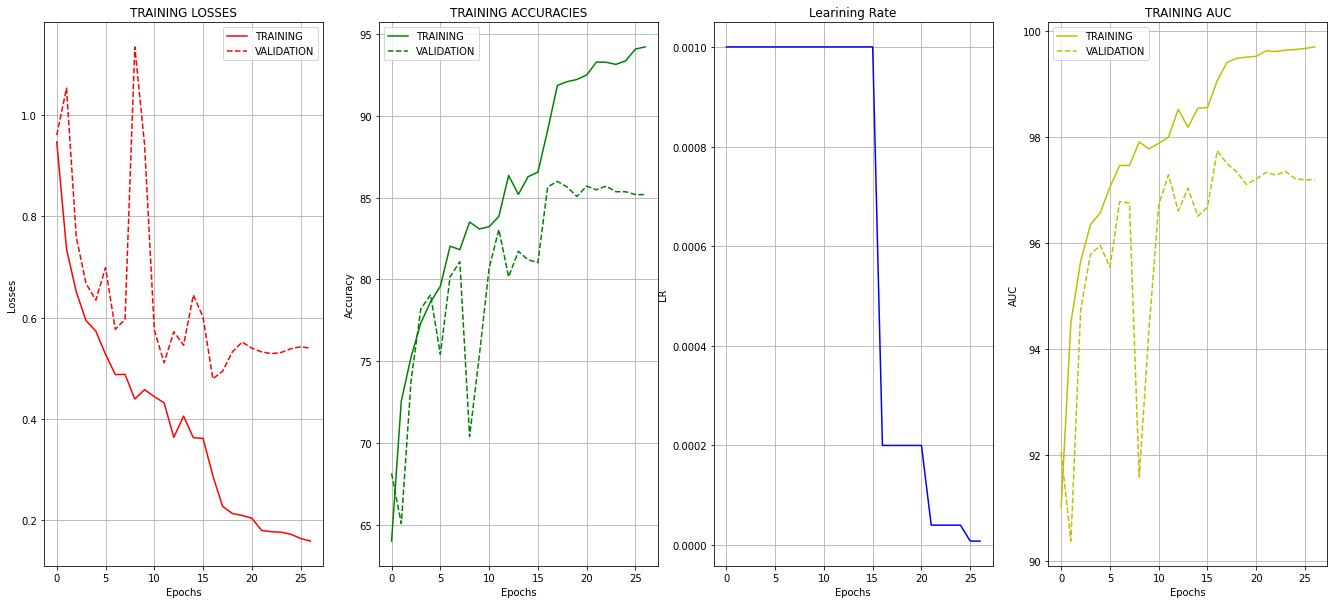

In [67]:
epochs = [d for d in range(len(training_history.history['loss']))]
loss = training_history.history['loss']; val_loss = training_history.history['val_loss']
acc = [d*100 for d in training_history.history['accuracy']]; val_acc = [d*100 for d in training_history.history['val_accuracy']]
auc = [d*100 for d in training_history.history['auc']]; val_auc = [d*100 for d in training_history.history['val_auc']]
lr = training_history.history['lr']

plt.figure(figsize = (23, 10))
plt.subplot(1, 4, 1)
plt.plot(epochs, loss, "-r", )
plt.plot(epochs, val_loss, "--r", )
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING LOSSES")

plt.subplot(1, 4, 2)
plt.plot(epochs, acc, "-g")
plt.plot(epochs, val_acc, "--g")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING ACCURACIES")

plt.subplot(1, 4, 3)
plt.plot(epochs, lr, "-b")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("LR")
plt.title("Learining Rate")

plt.subplot(1, 4, 4)
plt.plot(epochs, auc, "-y")
plt.plot(epochs, val_auc, "--y")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING AUC")

plt.savefig(os.path.join(WORK_DIR, f"{model.name}_training_history.png"));
plt.show();

model.save(os.path.join(WORK_DIR, f"{model.name}_{round(val_acc[-1])}.h5"))

# Performing a submission


In [70]:
os.listdir(WORK_DIR)

['attentive_ai_internship_hiring_challenge-dataset.zip',
 'sample_imgs.png',
 'effb0_avg_pretrained.png',
 'train_csv.csv',
 'test_csv.csv',
 'ResNet50_notTrained.png',
 'ResNet50_52.h5',
 'EffNet0_notTrained.png',
 'EffNetB0_training_history.png',
 'EffNetB0_67.09080338478088.h5',
 'EffNet0_preTrained.png',
 'ResNet50_preTrained.png',
 'ResNet50',
 'ResNet50_35.62752902507782.h5',
 'ResNet50_training_history.png',
 'ResNet50.png',
 'resnet50v2.png',
 'Transfer Learning for Optical Satellite Images.pdf',
 'resnet50v2_training_history.png',
 'resnet50v2_83.1116259098053.h5',
 'DockShip_BaseLineModel_InceptionResNetV2.ipynb',
 'efficientnetb4.png',
 'inception_resnet_v2.png',
 'inception_resnet_v2_training_history.png',
 'inception_resnet_v2_83.74783396720886.h5',
 'inception_resnet_v2_84.h5',
 'inception_resnet_v2_acc_84.h5',
 'xception.png',
 'xception_training_history.png',
 'xception_85.h5']

In [71]:
!ls ./ModelCheckpoints

efficientnetb4.h5  inception_resnet_v2_acc_84.h5  xception_acc_85.h5


In [72]:
sub_model = load_model(os.path.join(WORK_DIR, '/content/ModelCheckpoints/xception_acc_85.h5'))

In [73]:
!cp ./ModelCheckpoints/xception_acc_85.h5 ./drive/MyDrive/DockShip_Hiring_Challenge/

In [74]:
sub_model.evaluate(val_set)

28/28 [==============================] - 23s 768ms/step - loss: 0.4792 - accuracy: 0.8566 - auc: 0.9774


[0.47923243045806885, 0.856564462184906, 0.9773939251899719]

In [75]:
sub_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [49]:
# test_imgs = []; train_imgs = []
# for img_path in tqdm(test_csv.paths):
#     img = cv2.imread(img_path)
#     img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
#     test_imgs.append(img)

# for img_path in tqdm(train_csv.iloc[:len(test_csv), :].paths):
#     img = cv2.imread(img_path)
#     img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
#     train_imgs.append(img)

# test_imgs = np.array(test_imgs)
# train_imgs = np.array(train_imgs)

100%|██████████| 596/596 [00:02<00:00, 216.26it/s]


In [76]:
test_imgs.shape, train_imgs.shape

((596, 224, 224, 3), (596, 224, 224, 3))

In [77]:
def giveMeClass(x):
    for key, val in classes.items():
        if val == x:
            return key
    return -1

test_preds = sub_model.predict(test_imgs)
train_preds = sub_model.predict(train_imgs)
tpreds = []
trpreds = []
for test_pred in tqdm(test_preds):
    tpreds.append(np.argmax(test_pred))

for train_pred in tqdm(train_preds):
    trpreds.append(np.argmax(train_pred))

train_check = train_csv.iloc[:len(test_csv), :]

train_check['Model_preds'] = trpreds
train_check['Model_preds'] = train_check['Model_preds'].apply(lambda x: giveMeClass(x))

test_csv['Model_preds'] = tpreds
test_csv['Model_preds'] = test_csv['Model_preds'].apply(lambda x: giveMeClass(x))

100%|██████████| 596/596 [00:00<00:00, 209206.23it/s]


In [78]:
train_check

,0,1,paths,img_shape,kfold,Model_preds
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)",3.0,Adhered
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)",1.0,Adhered
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)",1.0,Concrete
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)",0.0,Concrete
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)",1.0,Plastic & fabric
...,...,...,...,...,...,...
591,591.jpg,Steel,./merged_data/train/591.jpg,"(3, 112, 127)",2.0,Steel
592,592.jpg,Plastic & fabric,./merged_data/train/592.jpg,"(3, 556, 666)",0.0,Plastic & fabric
593,593.jpg,Plastic & fabric,./merged_data/train/593.jpg,"(3, 719, 119)",1.0,Plastic & fabric
594,594.jpg,Plastic & fabric,./merged_data/train/594.jpg,"(3, 196, 166)",1.0,Plastic & fabric


In [79]:
test_csv

,0,1,paths,img_shape,Model_preds
0,0.jpg,Adhered,./merged_data/test/0.jpg,"(3, 609, 388)",Ballasted
1,1.jpg,Adhered,./merged_data/test/1.jpg,"(3, 90, 43)",Steel
2,2.jpg,Adhered,./merged_data/test/2.jpg,"(3, 211, 365)",Ballasted
3,3.jpg,Adhered,./merged_data/test/3.jpg,"(3, 1818, 913)",Concrete
4,4.jpg,Adhered,./merged_data/test/4.jpg,"(3, 433, 105)",Steel
...,...,...,...,...,...
591,591.jpg,Adhered,./merged_data/test/591.jpg,"(3, 4080, 3220)",Plastic & fabric
592,592.jpg,Adhered,./merged_data/test/592.jpg,"(3, 635, 682)",Steel
593,593.jpg,Adhered,./merged_data/test/593.jpg,"(3, 117, 284)",Plastic & fabric
594,594.jpg,Adhered,./merged_data/test/594.jpg,"(3, 901, 720)",Ballasted


In [80]:
print(classification_report(test_csv['1'], test_csv['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       1.00      0.18      0.30       596
       Ballasted       0.00      0.00      0.00         0
        Concrete       0.00      0.00      0.00         0
Plastic & fabric       0.00      0.00      0.00         0
         Shingle       0.00      0.00      0.00         0
           Steel       0.00      0.00      0.00         0

        accuracy                           0.18       596
       macro avg       0.17      0.03      0.05       596
    weighted avg       1.00      0.18      0.30       596



In [81]:
print(classification_report(train_check['1'], train_check['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       0.93      0.89      0.91       366
       Ballasted       0.68      0.89      0.77        19
        Concrete       0.86      0.75      0.80        65
Plastic & fabric       0.96      0.82      0.89        57
         Shingle       1.00      0.83      0.91        35
           Steel       0.58      0.93      0.71        54

        accuracy                           0.87       596
       macro avg       0.83      0.85      0.83       596
    weighted avg       0.89      0.87      0.87       596



In [83]:
submission = test_csv[['0', 'Model_preds']]
submission.rename({'Model_preds': "1"}, axis = 1, inplace = True)
submission.to_csv('output.csv', index = False)
submission

,0,1
0,0.jpg,Ballasted
1,1.jpg,Steel
2,2.jpg,Ballasted
3,3.jpg,Concrete
4,4.jpg,Steel
...,...,...
591,591.jpg,Plastic & fabric
592,592.jpg,Steel
593,593.jpg,Plastic & fabric
594,594.jpg,Ballasted
